In [1]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, minmax_scale
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tabulate import tabulate
from pprint import pprint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/extracted_features_iemocap.csv"
SCALED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/scaled_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"
AUDIO_SPECTOGRAMS_DIR = './../data/spectograms/'

config = Configuration.load_json(CONFIG_FILE)

OneHotEncodingConfig = {'0': [1, 0, 0, 0], '1': [0, 1, 0, 0], '2': [0, 0, 1, 0], '3': [0, 0, 0, 1]}
plt.rcParams['figure.dpi'] = 300

In [5]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
emotion_id_label = {
  0: "angry",
  1: "happy",
  2: "neutral",
  3: "sad",
}
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
print(f"Number of Audio Files: {df.shape[0]}")
df

Number of Audio Files: 5531


,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,std_chroma_stft,mean_zcr,...,max_mfcc6,min_mfcc7,var_mfcc9,max_mfcc9,max_mfcc10,max_mfcc13,var_mfcc14,var_mfcc15,min_mfcc17,min_mfcc19
File,,,,,,,,,,,,,,,,,,,,,
Ses01F_impro01_F012,improvised,Female,2.750,angry,0,2.0,3.5,3.5,0.296270,0.082856,...,39.327560,-40.651329,42.375973,19.492970,19.512123,18.821735,47.666279,51.472340,-18.892769,-27.943581
Ses01F_impro04_F028,improvised,Female,2.010,angry,0,2.0,3.5,3.5,0.319851,0.086560,...,62.818893,-40.228039,84.092949,24.274593,11.059961,36.497154,29.247034,61.287384,-17.456673,-15.254041
Ses01F_impro04_F029,improvised,Female,3.160,angry,0,1.5,4.0,4.0,0.298296,0.085880,...,29.858166,-33.455795,164.847565,34.833263,22.882631,33.635147,118.356186,128.460770,-32.842518,-12.516586
Ses01F_impro04_F030,improvised,Female,3.185,angry,0,1.5,3.5,4.0,0.316109,0.106300,...,48.537384,-38.774422,178.178299,24.138340,11.319570,35.046803,183.465393,119.128494,-13.127378,-24.713459
Ses01F_impro04_F031,improvised,Female,4.400,angry,0,1.5,3.0,3.5,0.314387,0.065918,...,44.125771,-49.090309,100.364433,35.686844,29.594337,11.990172,68.253944,51.992161,-20.573139,-20.019981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ses05M_script03_1_M029,scripted,Male,6.900,happy,1,4.5,4.0,4.0,0.314659,0.076922,...,67.401619,-45.718887,135.744736,24.121601,21.941551,27.634800,60.783833,75.600899,-29.983742,-29.306610
Ses05M_script03_1_M030,scripted,Male,5.350,happy,1,4.5,4.5,3.5,0.321043,0.072086,...,56.760414,-32.512886,204.404785,19.456440,15.695395,23.099380,42.960770,68.624123,-31.964703,-23.853745
Ses05M_script03_1_M031,scripted,Male,2.700,happy,1,2.5,3.5,3.5,0.301189,0.065505,...,32.699459,-34.928909,88.746170,11.523495,14.310634,27.999563,86.148201,38.718422,-30.572651,-17.003326


# MinMax Scaling

In [3]:
df[df.columns[8:]] = minmax_scale(df[df.columns[8:]], config.scale_range)
# df.to_csv(SCALED_FEATURES_FILE)

## Testing out the models

In [6]:
def get_metrics(y_labels, y_pred, draw_corr_matrix=True):
    folds_size = 1106
    accs = []
    i = 0
    for f_i in range(5):
        if f_i == 1:
            folds_size -= 1
        acc = round(metrics.accuracy_score(
            y_labels[i:i+folds_size], y_pred[i:i+folds_size]) * 100, 2)
        print(f"Accuracy for fold {f_i}: {acc}%")
        i += folds_size
        accs.append(acc)

    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    if draw_corr_matrix:
        ticks = ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()

def categorical_cross_validation(get_new_model, cv=5, draw_corr_matrix=True):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,8:]
    y = df.iloc[:,4:5]
    all_y_pred = []
    all_y_labels = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

Accuracy for fold 0: 59.76%
Accuracy for fold 1: 60.63%
Accuracy for fold 2: 60.18%
Accuracy for fold 3: 61.0%
Accuracy for fold 4: 59.64%

Metric             Value
-----------------  -----------
Accuracy           60.26+-0.51
F1 score macro     60.93
Precision          61.93
Recall             60.49
Matthews corrcoef  0.462


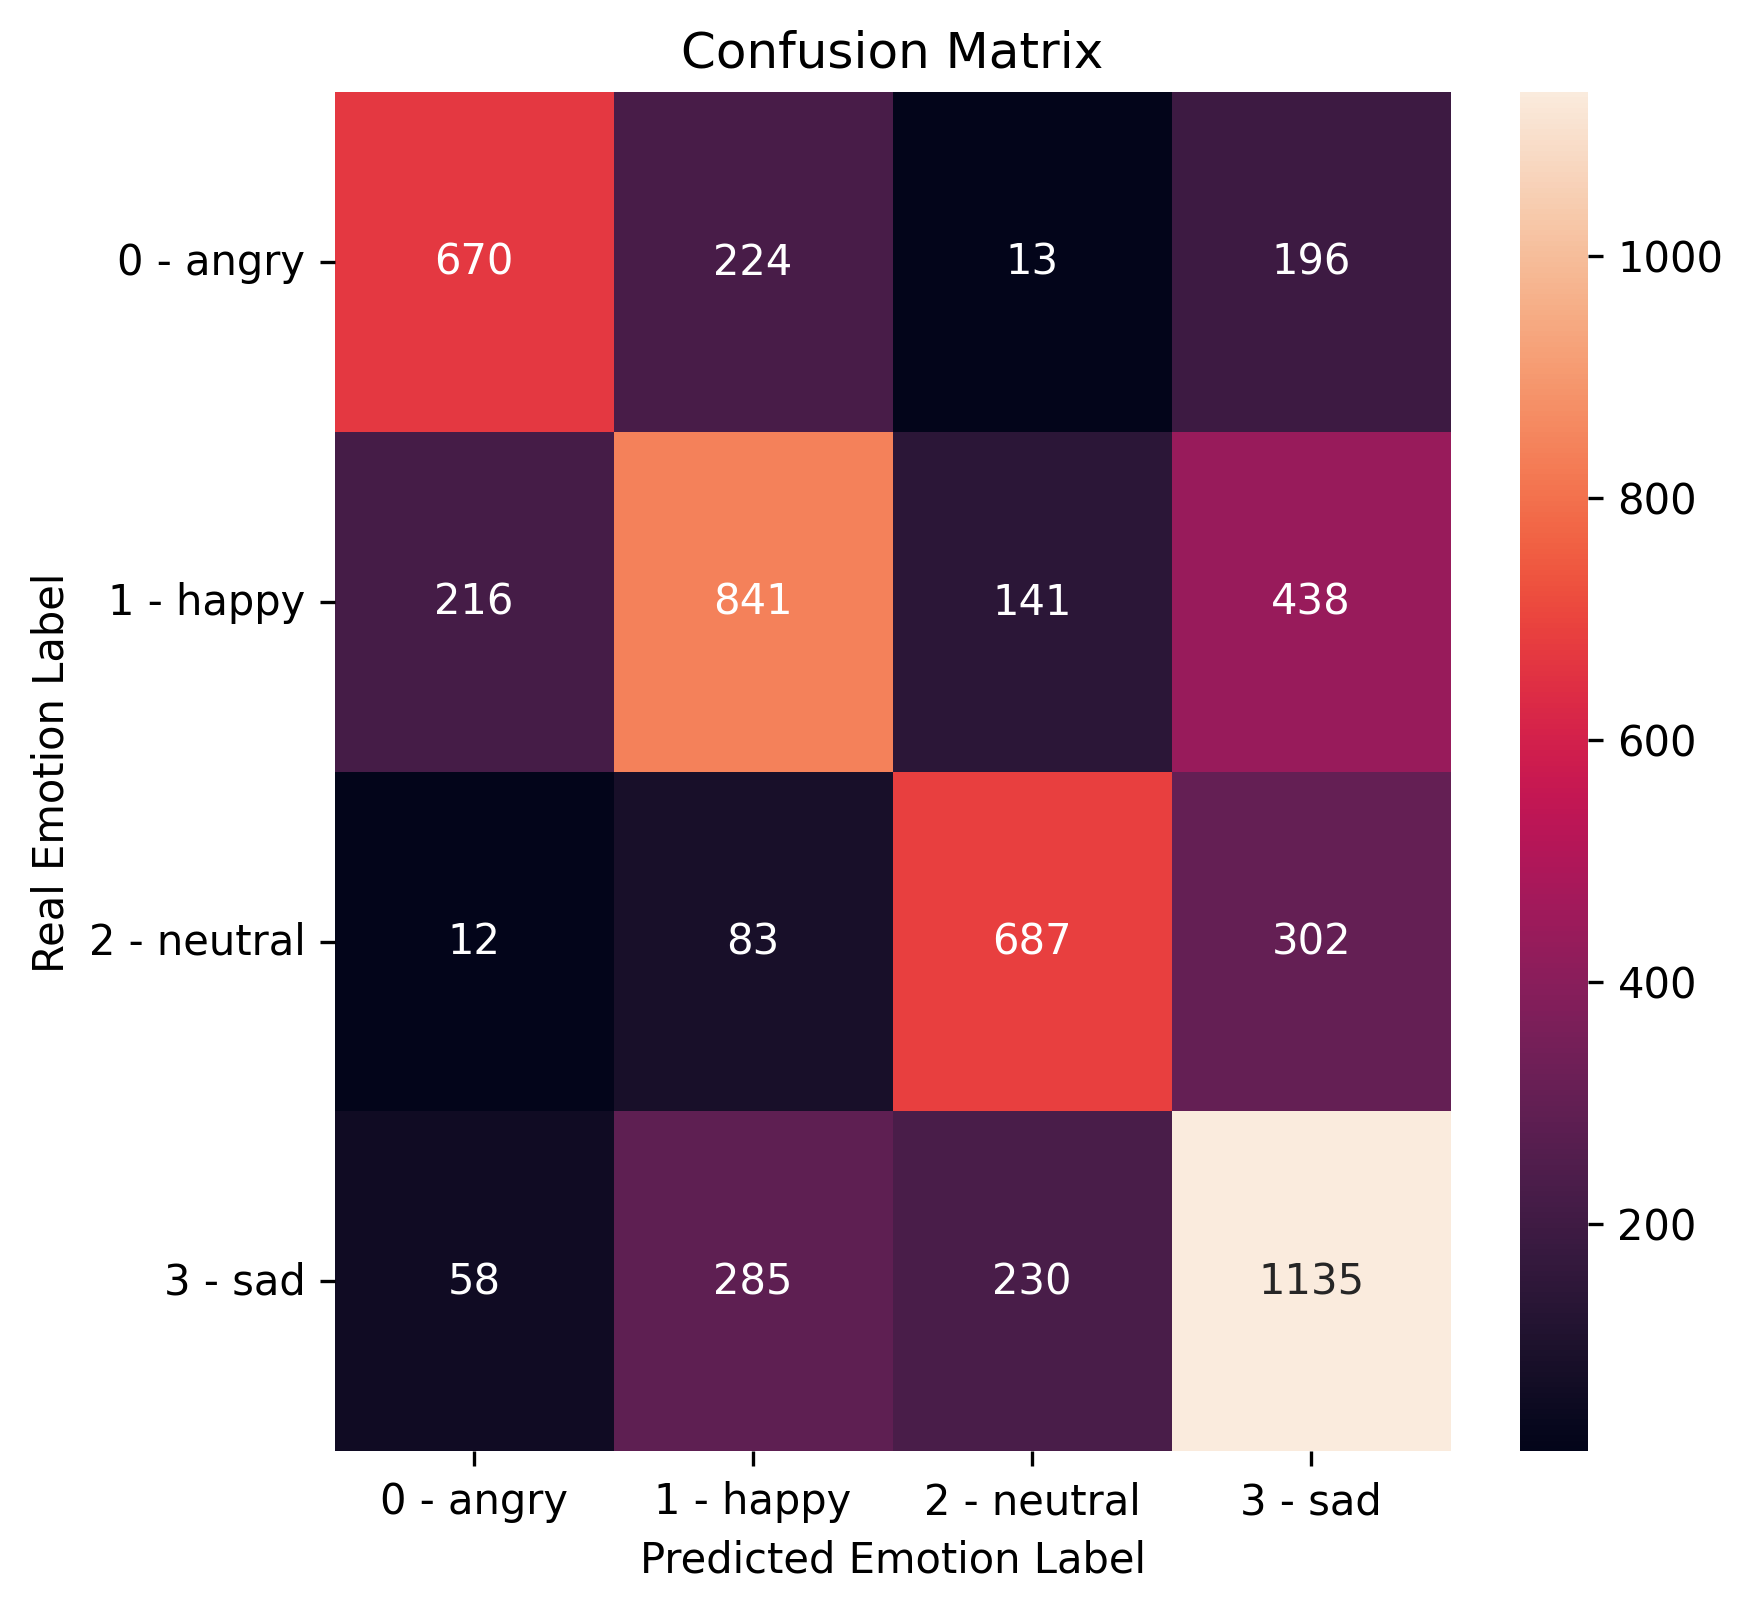

In [7]:
def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 58.95%
Accuracy for fold 1: 57.5%
Accuracy for fold 2: 60.49%
Accuracy for fold 3: 60.04%
Accuracy for fold 4: 58.23%

Metric             Value
-----------------  -----------
Accuracy           59.05+-1.11
F1 score macro     59.83
Precision          60.5
Recall             59.57
Matthews corrcoef  0.446


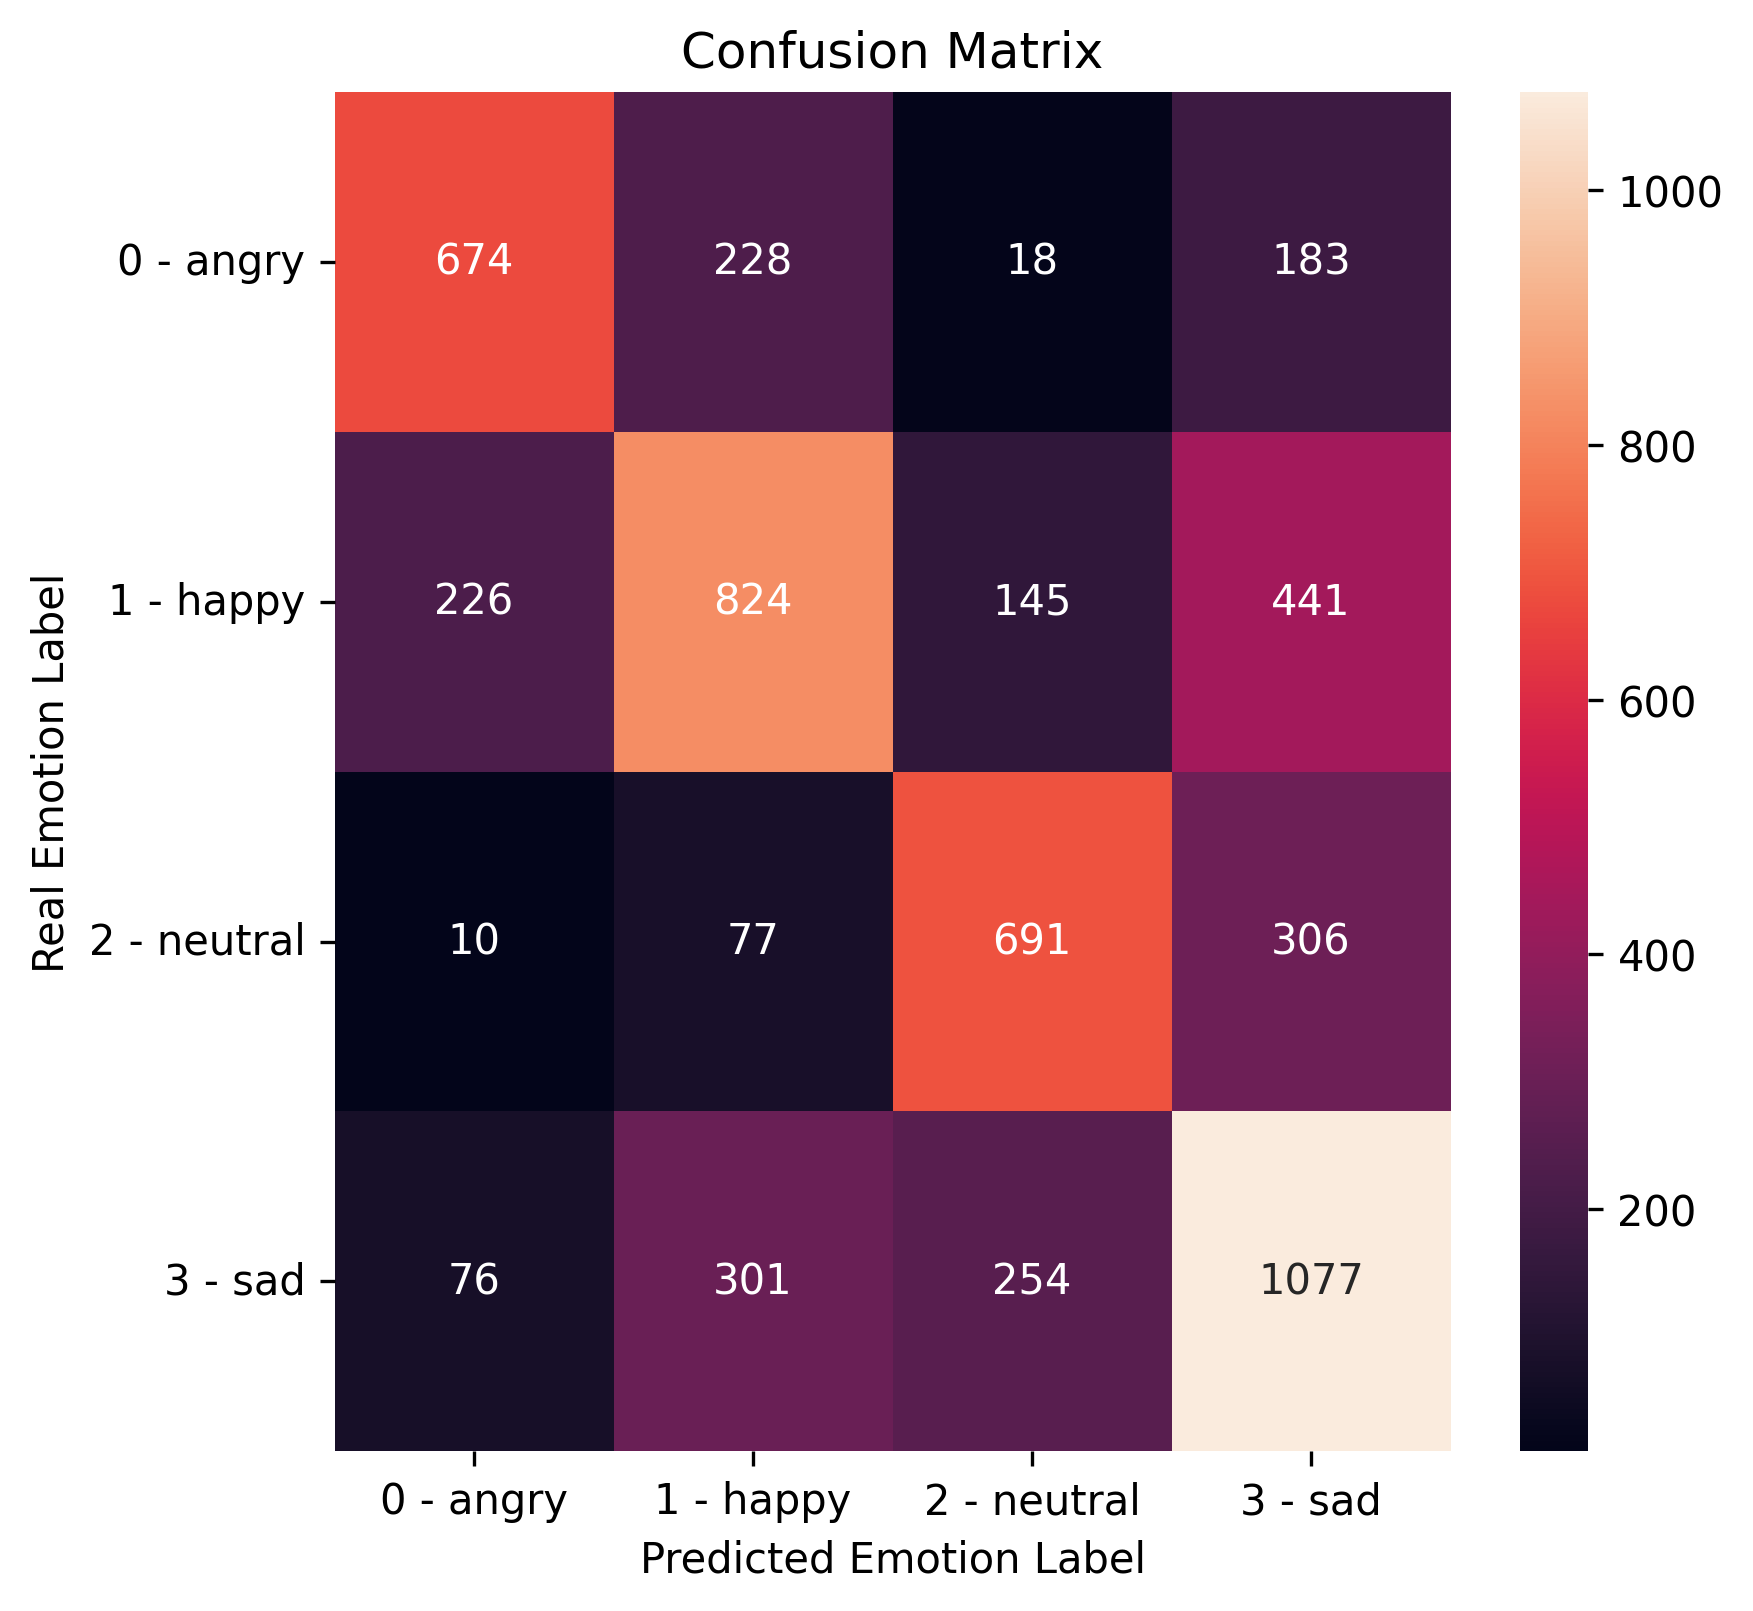

In [25]:
def get_new_model():
    return GradientBoostingClassifier(random_state=1, max_features=8)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 59.31%
Accuracy for fold 1: 60.31%
Accuracy for fold 2: 60.58%
Accuracy for fold 3: 59.67%
Accuracy for fold 4: 60.04%

Metric             Value
-----------------  -----------
Accuracy           59.99+-0.45
F1 score macro     60.6
Precision          61.63
Recall             60.17
Matthews corrcoef  0.458


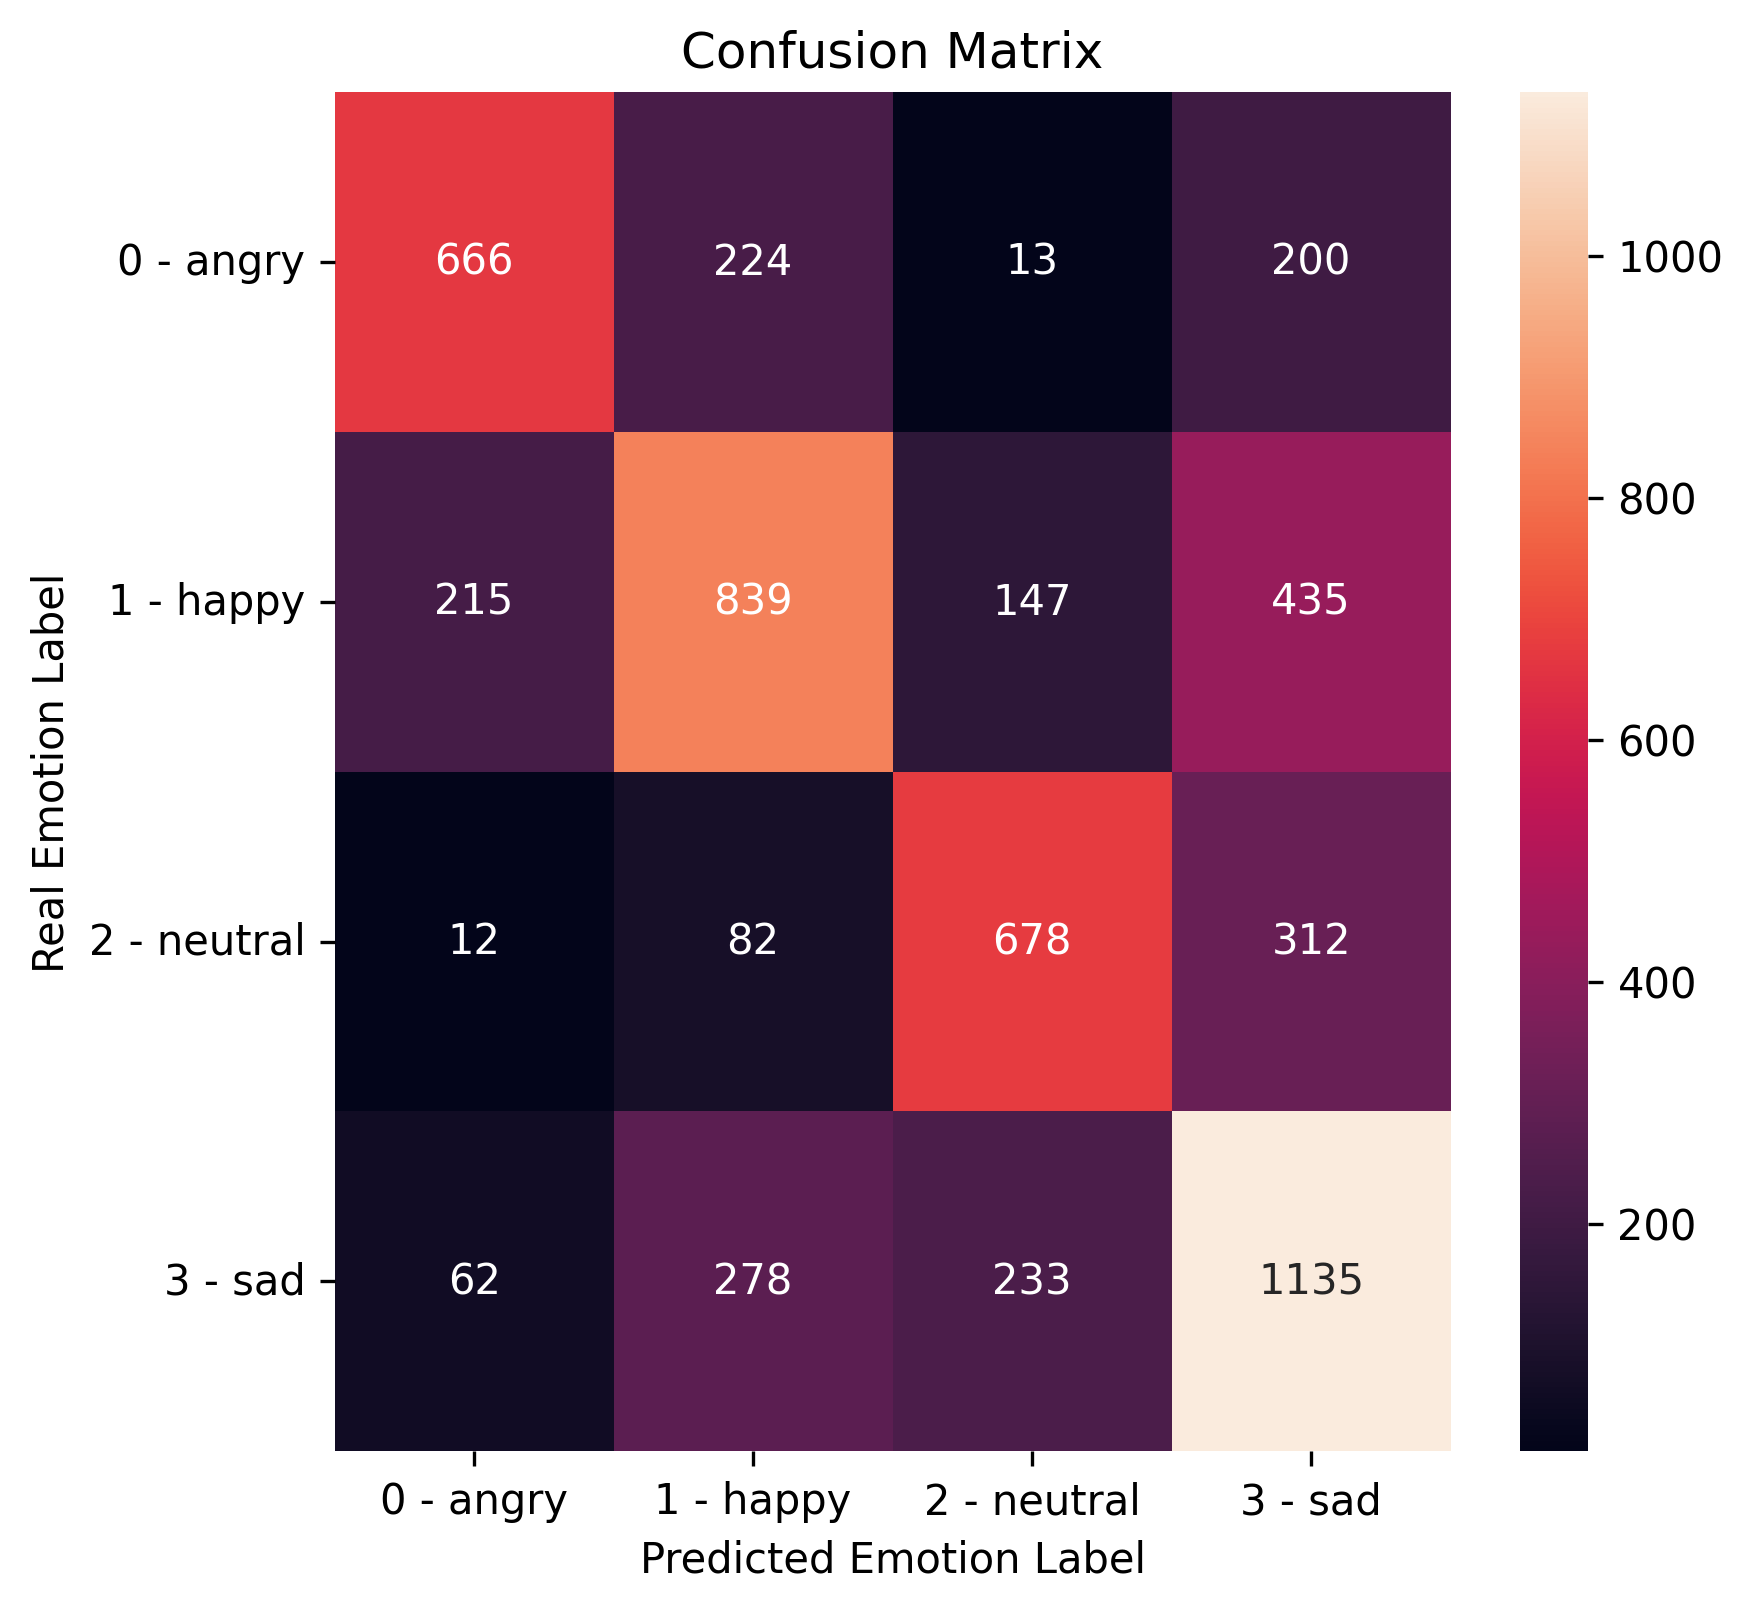

In [26]:
def get_new_model():
    return AdaBoostClassifier(random_state=1, base_estimator=RandomForest(n_estimators=512, n_jobs=-1, random_state=1))
categorical_cross_validation(get_new_model)


Accuracy for fold 0: 58.32%
Accuracy for fold 1: 57.78%
Accuracy for fold 2: 58.32%
Accuracy for fold 3: 57.87%
Accuracy for fold 4: 56.87%

Metric             Value
-----------------  -----------
Accuracy           57.84+-0.53
F1 score macro     58.43
Precision          57.99
Recall             60.36
Matthews corrcoef  0.441


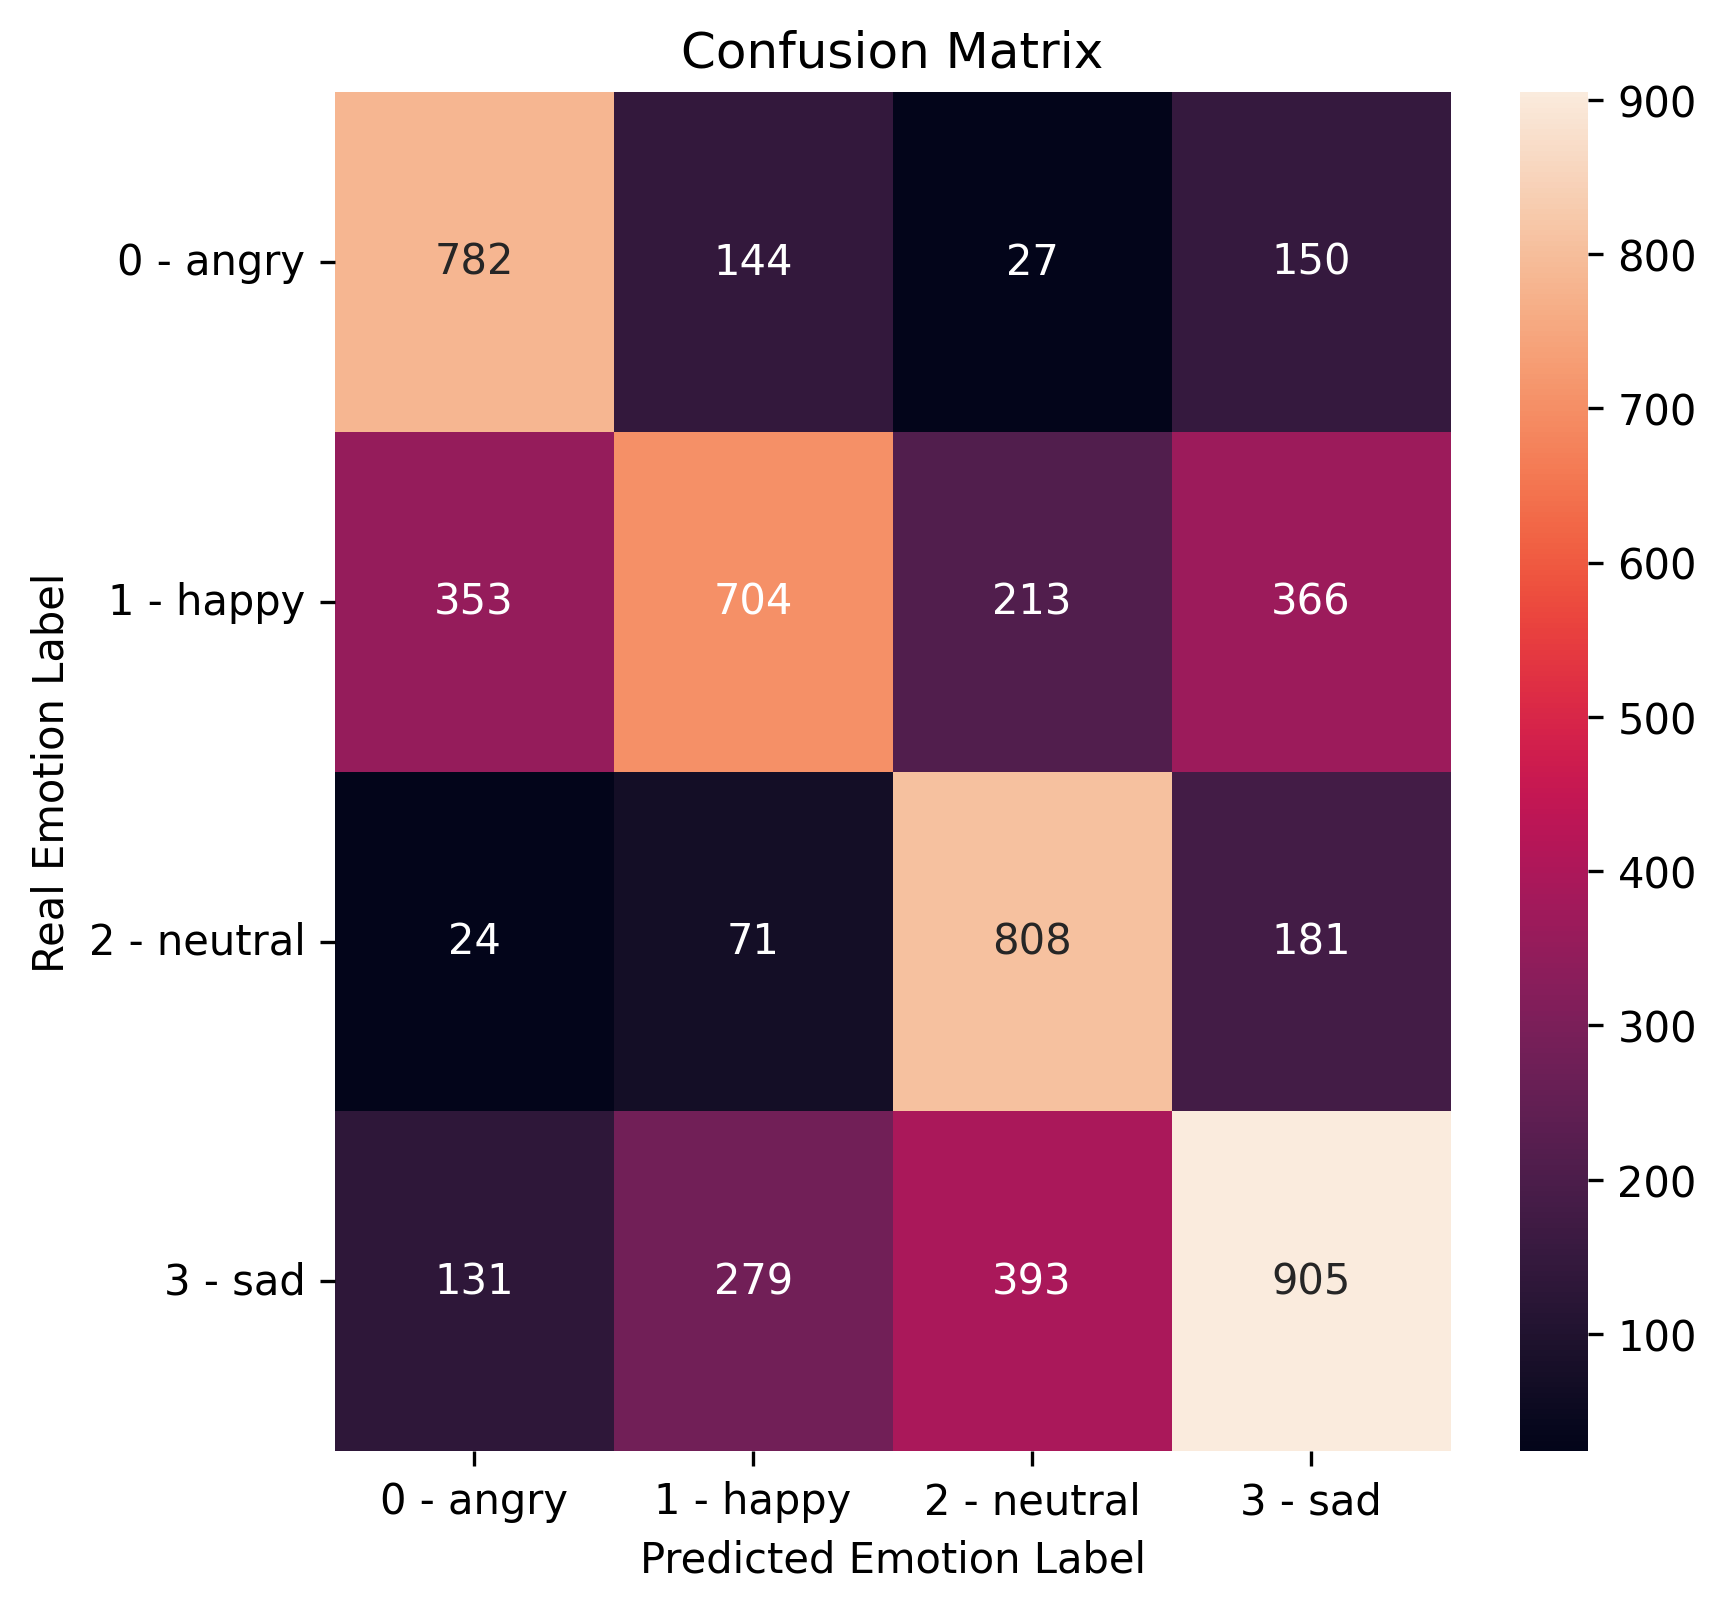

In [27]:
def get_new_model():
    return BalancedRandomForestClassifier(random_state=1, max_features=8)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 60.31%
Accuracy for fold 1: 59.76%
Accuracy for fold 2: 59.04%
Accuracy for fold 3: 59.76%
Accuracy for fold 4: 59.58%

Metric             Value
-----------------  ----------
Accuracy           59.7+-0.41
F1 score macro     60.38
Precision          61.47
Recall             59.93
Matthews corrcoef  0.454


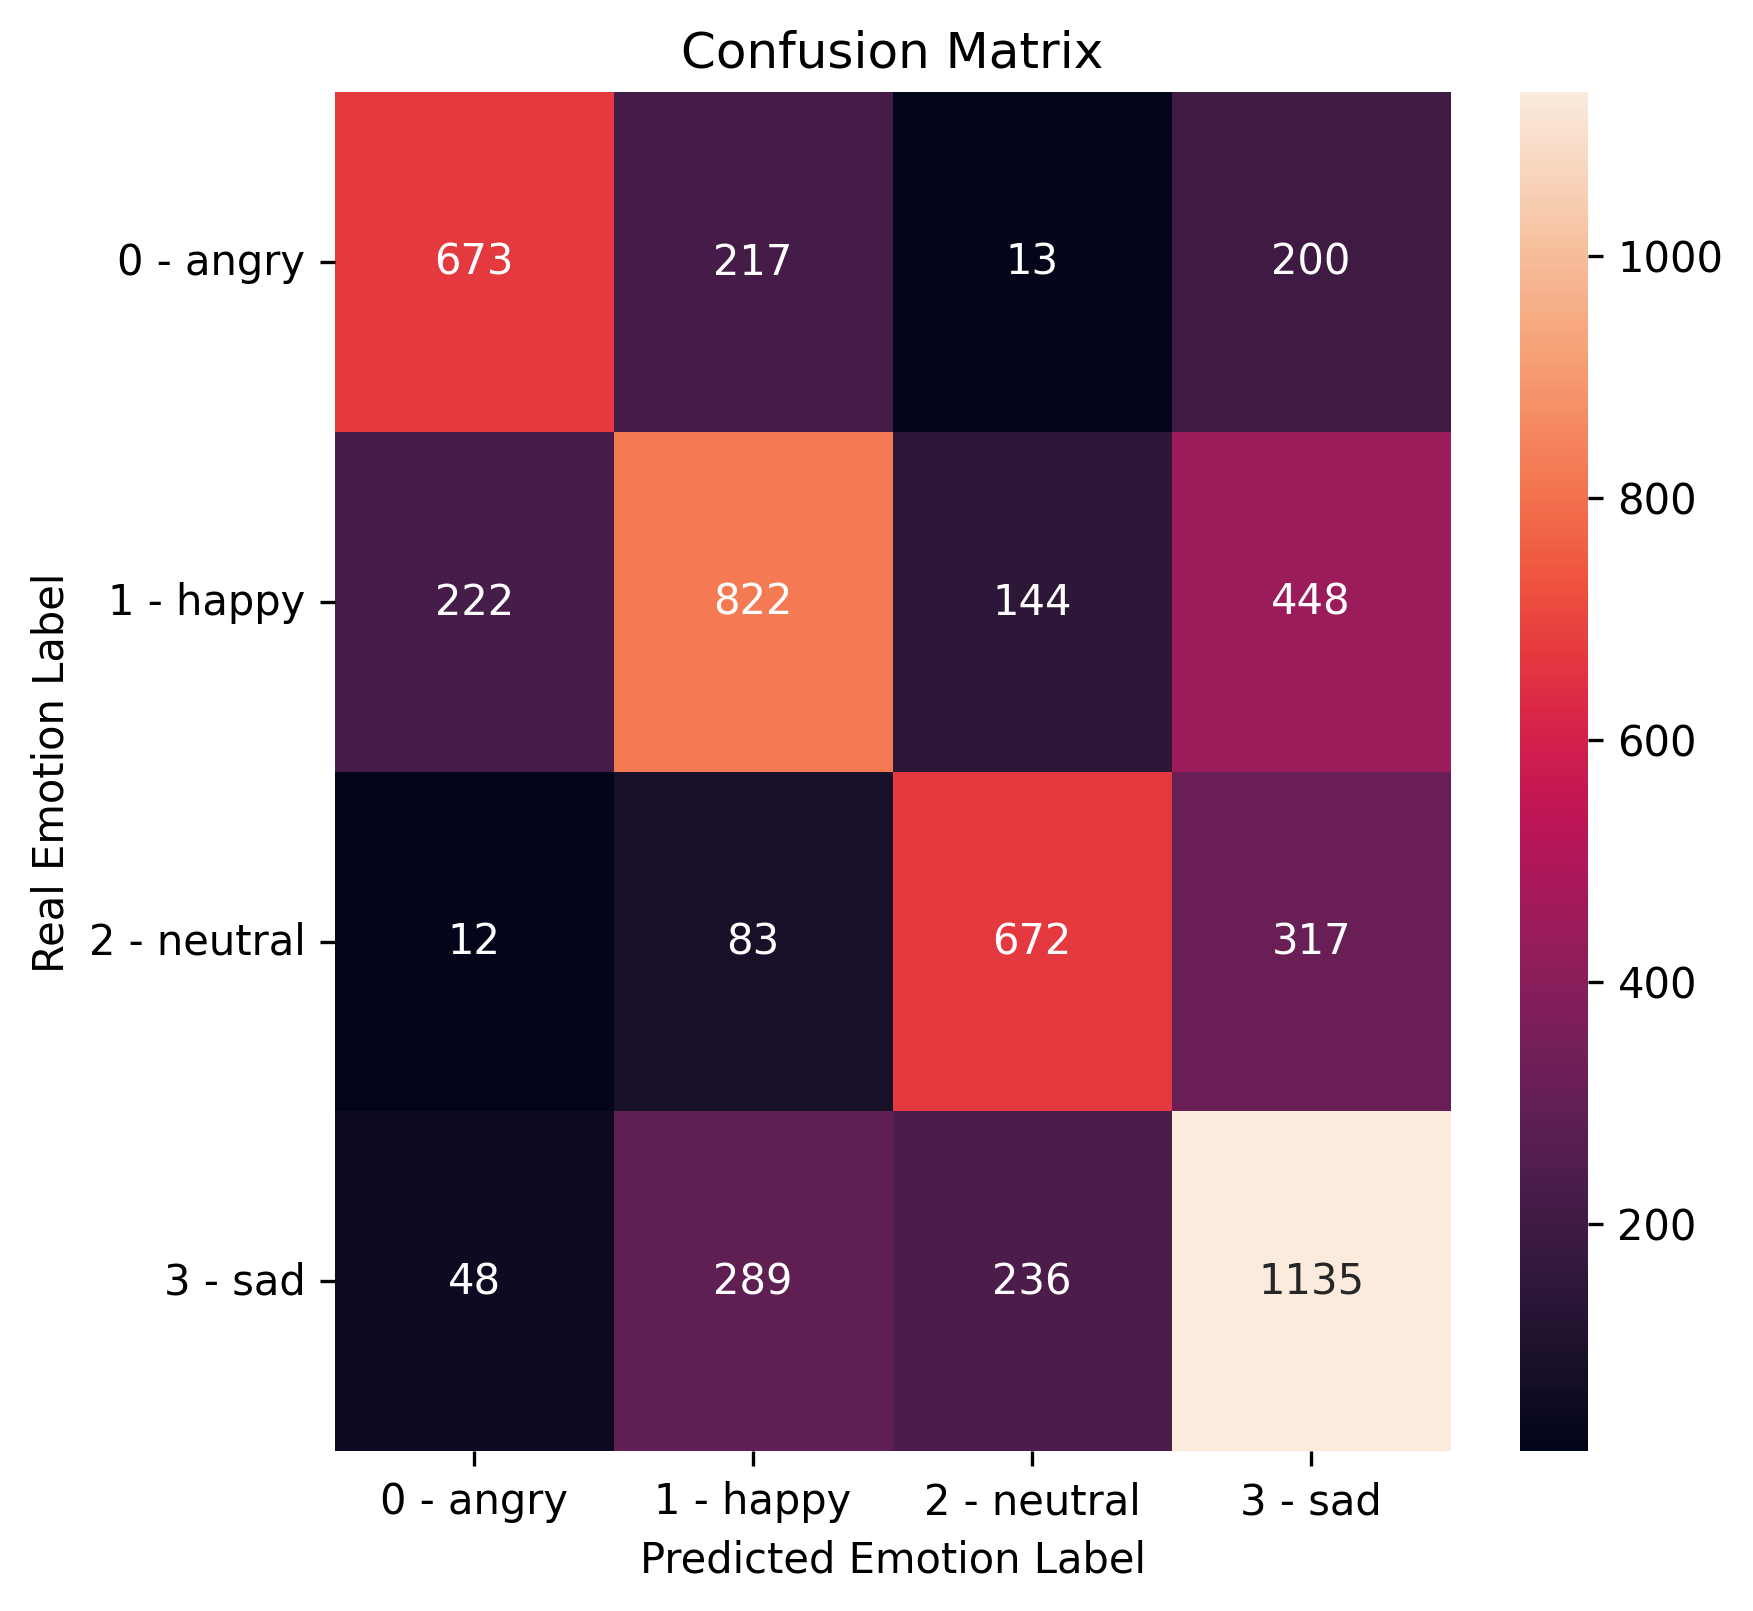

In [28]:
def get_new_model():
  return RandomForest(max_features=4, n_estimators=512, n_jobs=-1,
                       random_state=1, warm_start=True)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 56.06%
Accuracy for fold 1: 56.24%
Accuracy for fold 2: 55.79%
Accuracy for fold 3: 55.42%
Accuracy for fold 4: 55.79%

Metric             Value
-----------------  -----------
Accuracy           55.87+-0.28
F1 score macro     56.82
Precision          56.97
Recall             56.86
Matthews corrcoef  0.403


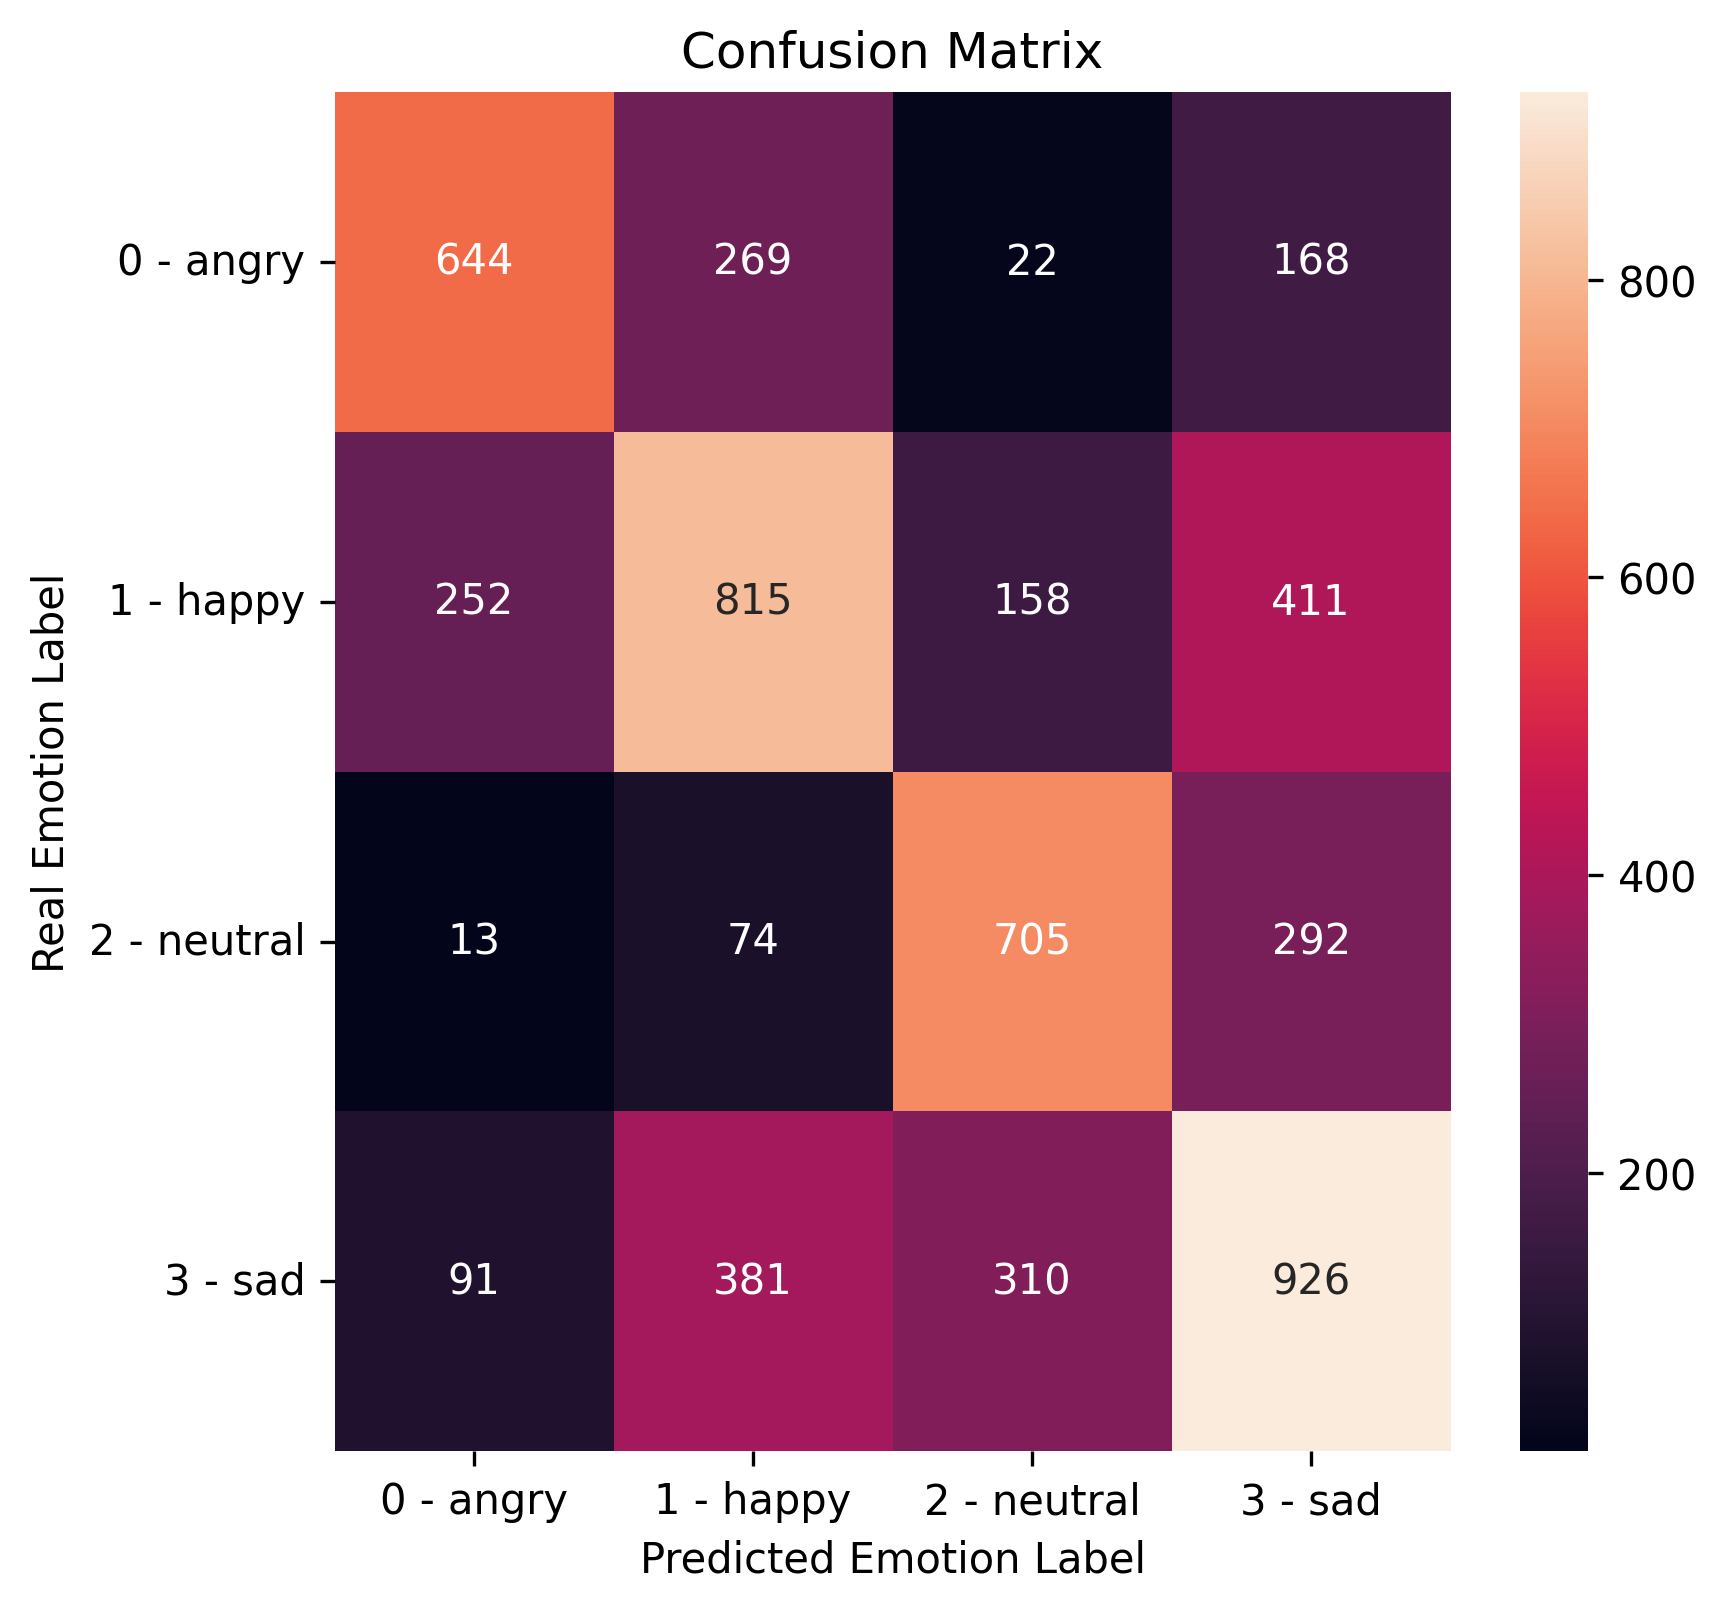

In [29]:
def get_new_model():
    return LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr',
                           tol=0.00010000000000000009)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 60.58%
Accuracy for fold 1: 60.22%
Accuracy for fold 2: 60.31%
Accuracy for fold 3: 59.58%
Accuracy for fold 4: 59.22%

Metric             Value
-----------------  ----------
Accuracy           59.99+-0.5
F1 score macro     60.87
Precision          61.41
Recall             60.57
Matthews corrcoef  0.458


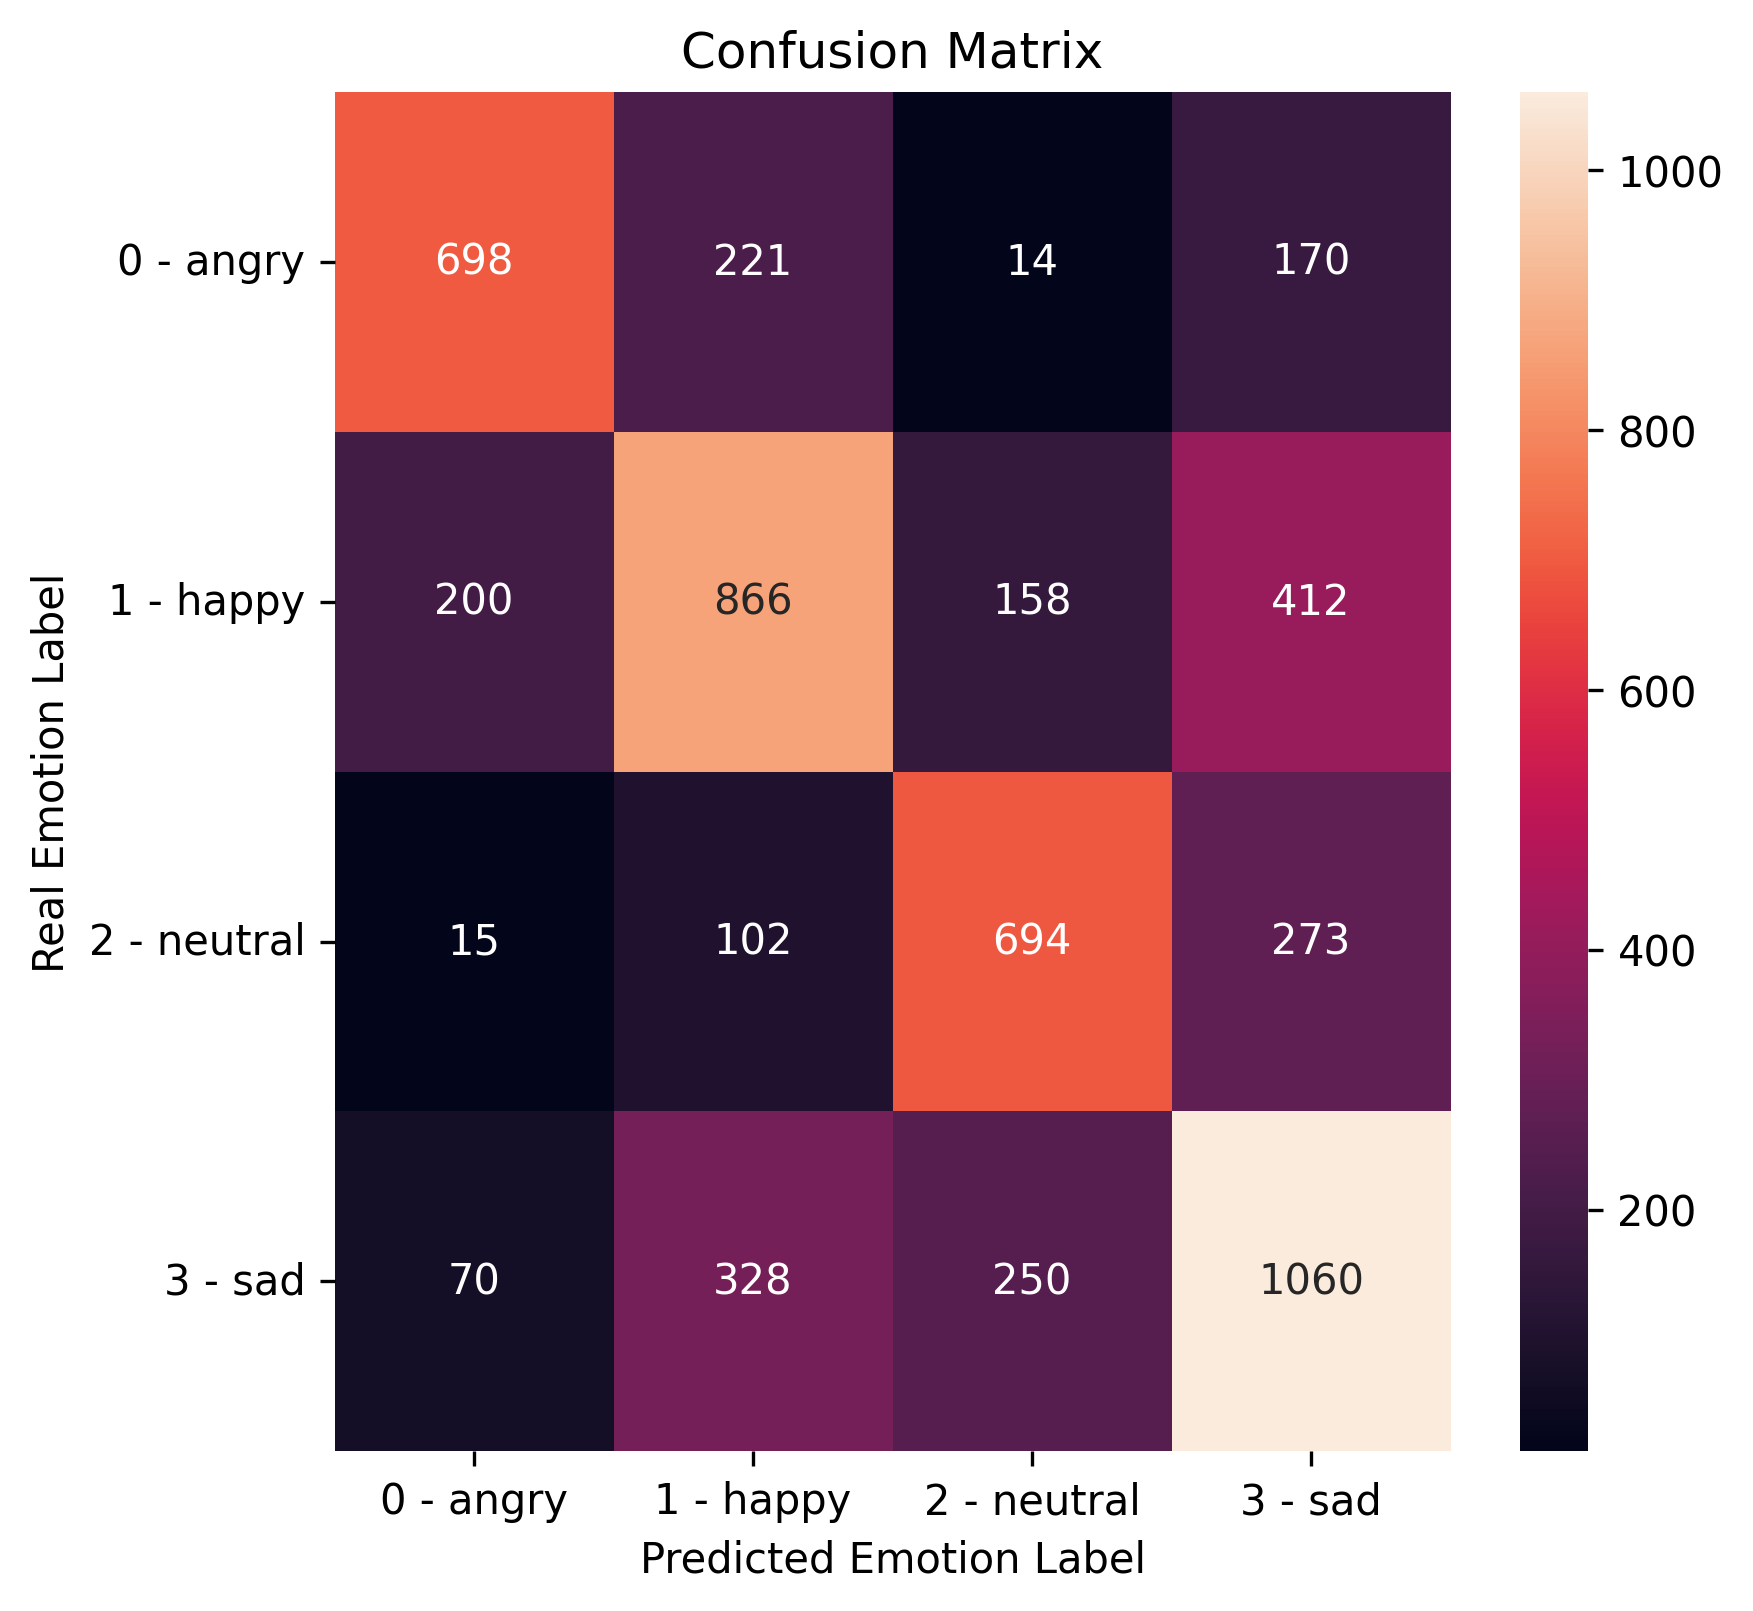

In [30]:
def get_new_model():
    return HistGradientBoostingClassifier(early_stopping=False,
                                          l2_regularization=2.188553300996835e-10,
                                          learning_rate=0.06138190336151616, max_iter=512,
                                          max_leaf_nodes=20, n_iter_no_change=0,
                                          random_state=1, validation_fraction=None,
                                          warm_start=True)
categorical_cross_validation(get_new_model)

In [5]:
def build_model_1(input_shape=(24, 1), loss=SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    model = Sequential([
        LSTM(123, return_sequences=False, input_shape=(24, 1)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(4, activation='softmax'),
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape=(24, 1), loss=loss, optimizer=optimizer)


get_new_model().summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 lstm (LSTM)                 (None, 123)               61500     Y          
                                                                            
 dense (Dense)               (None, 64)                7936      Y          
                                                                            
 dropout (Dropout)           (None, 64)                0         Y          
                                                                            
 dense_1 (Dense)             (None, 32)                2080      Y          
                                                                            
 dropout_1 (Dropout)         (None, 32)                0         Y          
                                                                            
 dense_2 (Dense)             (None, 4)                 1

Epoch 1/100
35/35 [==============================] - 4s 79ms/step - loss: 1.3779 - accuracy: 0.2981 - val_loss: 1.3602 - val_accuracy: 0.3089
Epoch 2/100
35/35 [==============================] - 2s 60ms/step - loss: 1.3296 - accuracy: 0.3357 - val_loss: 1.2791 - val_accuracy: 0.3812
Epoch 3/100
35/35 [==============================] - 2s 67ms/step - loss: 1.2351 - accuracy: 0.3926 - val_loss: 1.1778 - val_accuracy: 0.4300
Epoch 4/100
35/35 [==============================] - 3s 75ms/step - loss: 1.2058 - accuracy: 0.4225 - val_loss: 1.1617 - val_accuracy: 0.4535
Epoch 5/100
35/35 [==============================] - 3s 84ms/step - loss: 1.1852 - accuracy: 0.4247 - val_loss: 1.1544 - val_accuracy: 0.4481
Epoch 6/100
35/35 [==============================] - 4s 107ms/step - loss: 1.1860 - accuracy: 0.4236 - val_loss: 1.1519 - val_accuracy: 0.4517
Epoch 7/100
35/35 [==============================] - 3s 71ms/step - loss: 1.1923 - accuracy: 0.4225 - val_loss: 1.1733 - val_accuracy: 0.4300
Epoch

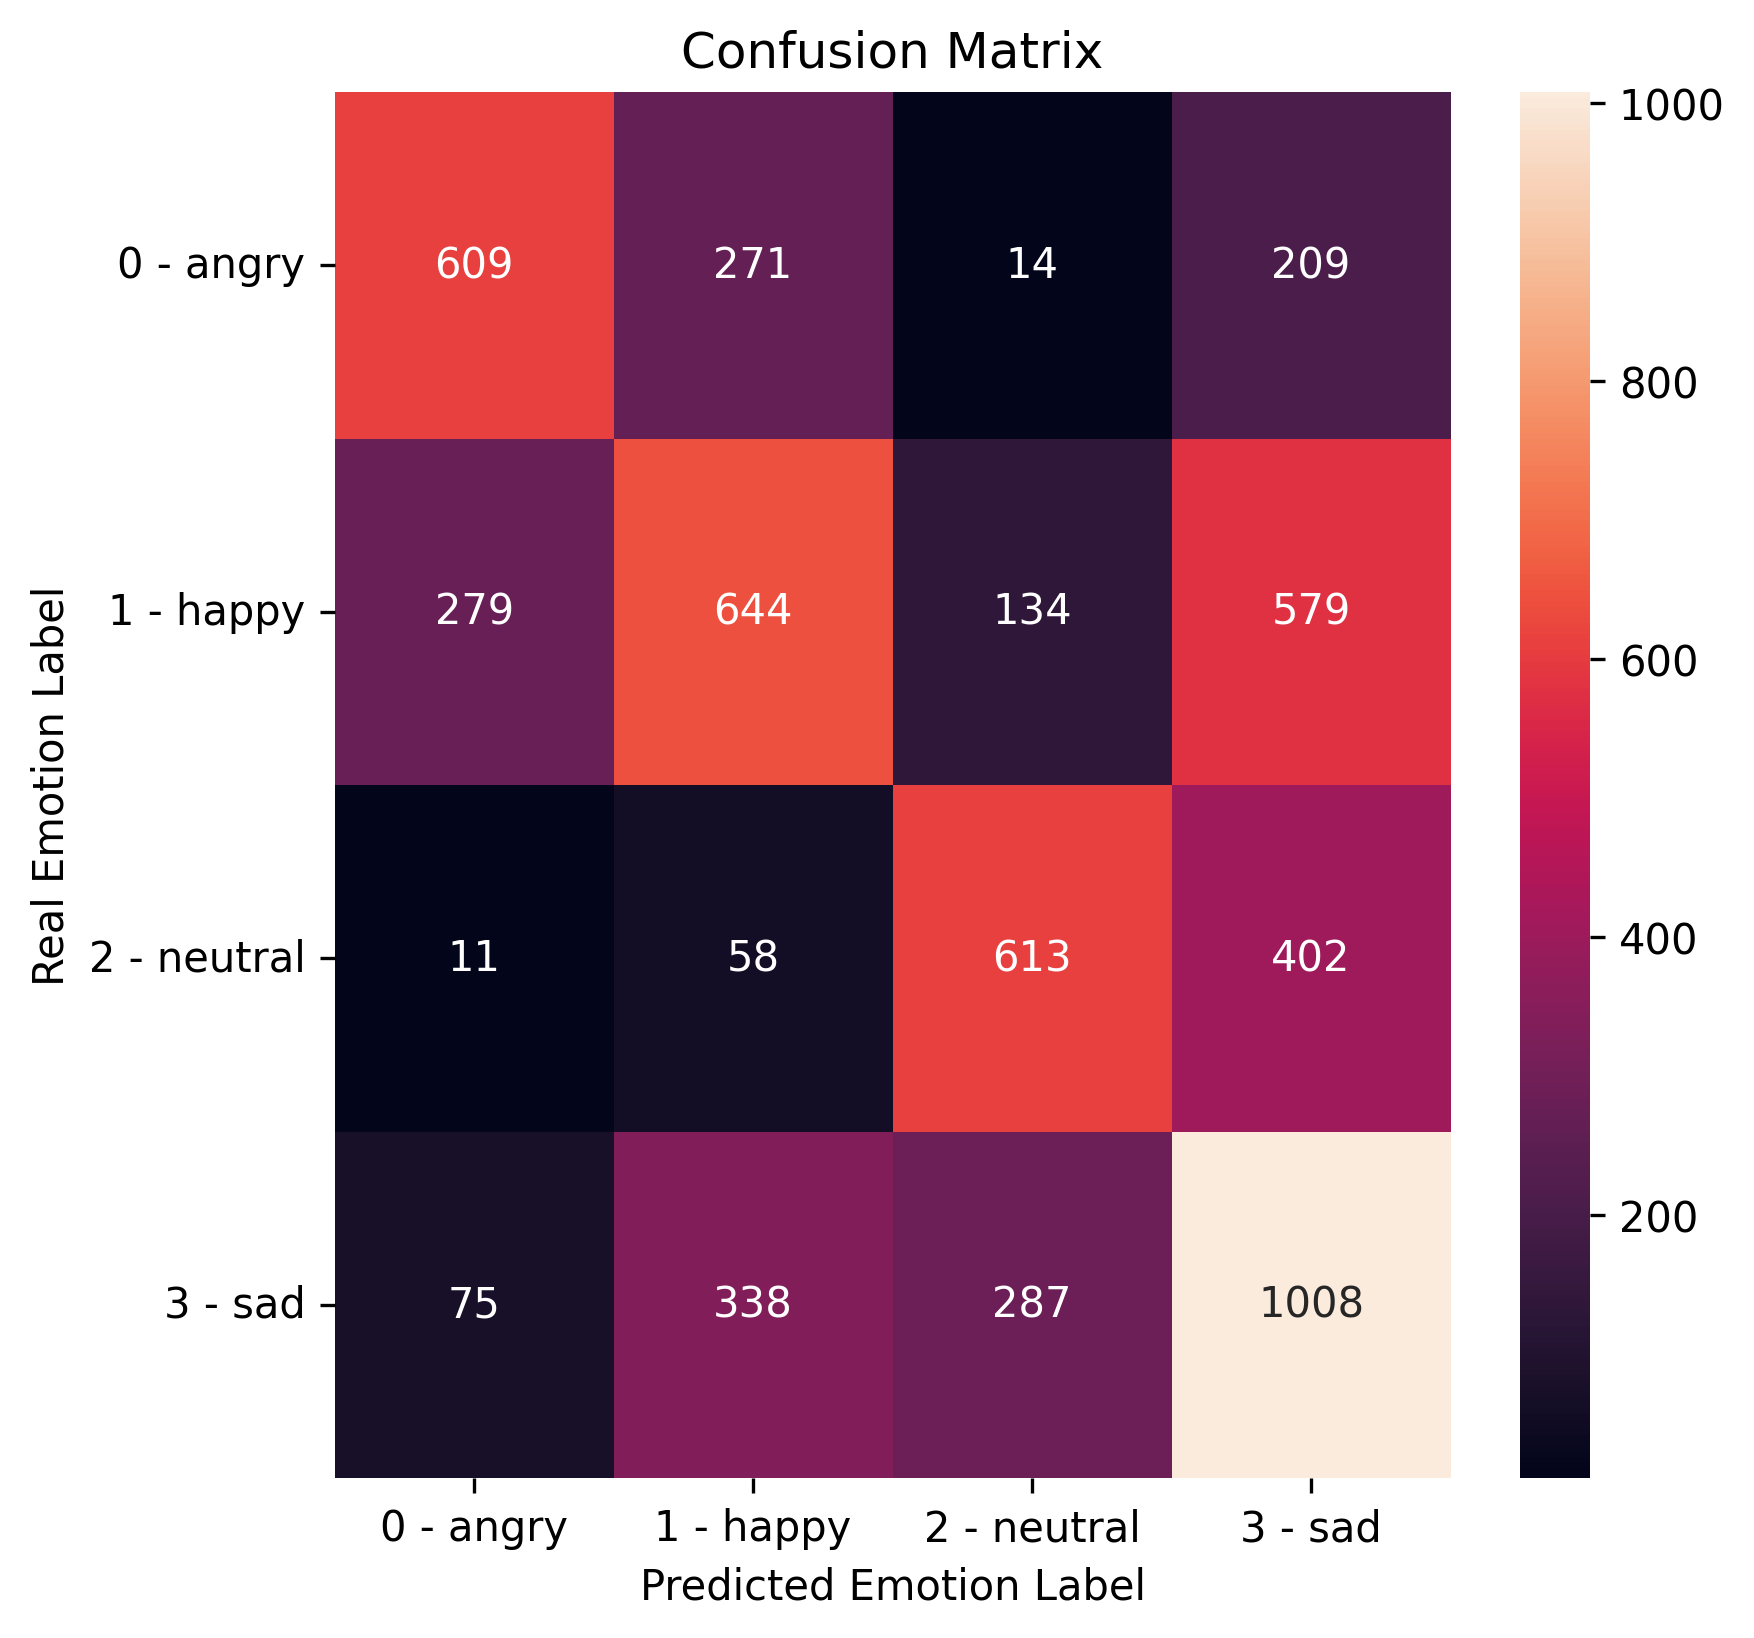

In [8]:
def categorical_cross_validation(get_new_model, callbacks, no_epochs, batch_size, verbosity=1, num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1

  X = df.iloc[:, 8:]
  y = df.iloc[:, 4:5]

  all_y_pred = []
  all_y_labels = []

  for train, test in kfold.split(X, y):
    model = get_new_model()

    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=callbacks,
              workers=8)

    y_pred = model.predict(X_test)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)
  
callback = EarlyStopping(monitor='val_loss', patience=10)
no_epochs = 100
batch_size = 128
verbosity = 1
num_folds = 5

categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)